<a href="https://colab.research.google.com/github/chomchom69420/bayesian-nn/blob/master/BNN_NN_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchbnn

In [ ]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)

In [ ]:
def target(x):
    return x.pow(5) -10* x.pow(1)+1

def noisy_target(x, noise):
    return target(x) + noise*(2*torch.rand(x.size())-1)

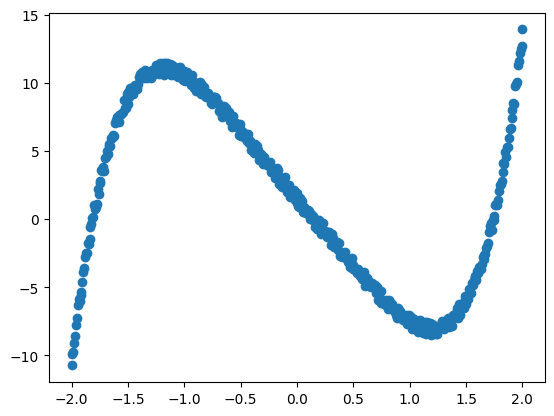

In [ ]:
x = torch.linspace(-2,1.25, 500)
y = noisy_target(x)
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [ ]:
model = nn.Sequential(
  bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
  nn.ReLU(),
  bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

In [ ]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for step in range(2000):
  pre = model(x)
  mse = mse_loss(pre, y)
  kl = kl_loss(model)
  cost = mse + kl_weight*kl

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.25, KL : 11.19


In [ ]:
x_test = torch.linspace(-2,2, 200)
y_test = noisy_target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

In [ ]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

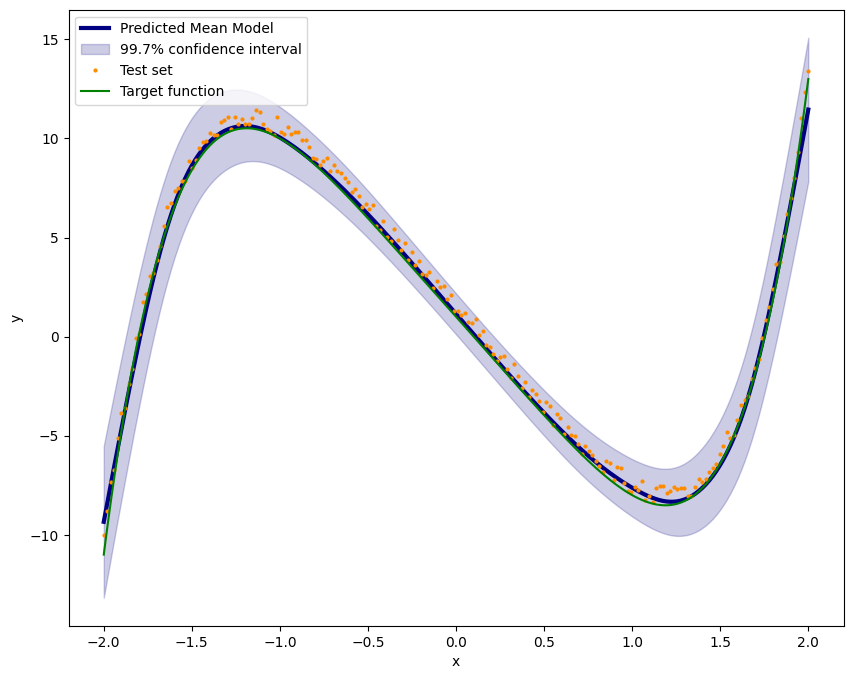

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
def bnn_model(noise):
  x = torch.linspace(-2,1.3, 500)
  y = noisy_target(x, noise)
  x = torch.unsqueeze(x, dim=1)
  y = torch.unsqueeze(y, dim=1)

  x_test = torch.linspace(-2,2, 300)
  y_test = noisy_target(x_test, noise)

  x_test = torch.unsqueeze(x_test, dim=1)
  y_test = torch.unsqueeze(y_test, dim=1)

  # bnn model training
  model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
  )

  mse_loss = nn.MSELoss()
  kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
  kl_weight = 0.01

  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for step in range(2000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

  print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

  # nn model training
  nn_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1000),
    nn.ReLU(),
    nn.Linear(in_features=1000, out_features=1),
  )

  nn_criterion = nn.MSELoss()  # Mean Squared Error for regression
  nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

  for epoch in range(2000):
    nn_model.train()  # Set the model to training mode
    nn_optimizer.zero_grad()  # Clear gradients from the previous step
    nn_predictions = nn_model(x)  # Forward pass
    nn_loss = nn_criterion(nn_predictions, y)  # Compute the loss
    nn_loss.backward()  # Backpropagation
    nn_optimizer.step()  # Update weights


  print(f"Loss: {nn_loss.item():.4f}")

  # Evaluation
  nn_model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      nn_predictions = nn_model(x_test)

  models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
  models_result = models_result[:,:,0]
  models_result = models_result.T
  mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
  std_values = np.array([models_result[i].std() for i in range(len(models_result))])

  plt.figure(figsize=(6,4))
  plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
  plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
  #plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
  plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
  plt.plot(x_test.data.numpy(),target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
  plt.plot(x_test.data.numpy(),nn_predictions.data.numpy(),color='red',lw=1,label='Equivalent NN')
  plt.title('Regression BNN vs NN for missing training set.')
  plt.grid()
  plt.legend()
  plt.xlabel('$x$')
  plt.ylabel('$y=f(x)$')
  plt.savefig('bnn_vs_nn.pdf')
  plt.show()

- MSE : 1.13, KL : 8.02
Loss: 0.3147


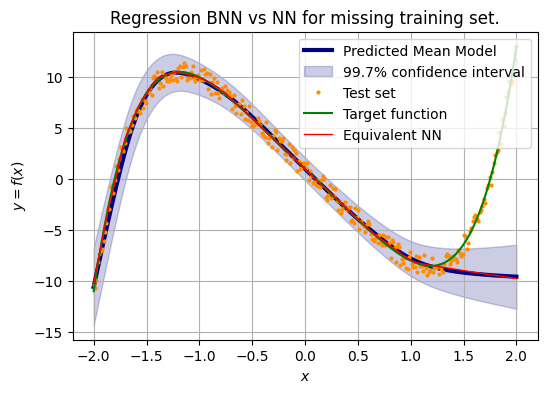

In [ ]:
bnn_model(1)